# Load Spark notebook #

`Adarshs-MacBook-Pro:spark-2.0.1-bin-hadoop2.7 adarshnair$ PYSPARK_DRIVER_PYTHON="/Users/adarshnair/graphlab/anaconda/bin/jupyter-notebook" ./bin/pyspark`

# Spark regression models #

There are 3 criterions to consider when comparing classification and regression models in Spark:

* Loss function
* Link function: for regression it is the identity link function which assumes normal distribution of data.
* Decision function

<img src ="linkfunction.png">
Image taken from https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function

Sparks MLlib library allows for two different kinds of regression models:

* Linear models: Least squares regression with L1(lasso) or L2(ridge) regularization. Loss function used squared loss.

This is susceptible to outliers in the data and also to over fitting. 

* Decision trees: Uses 'variance' as the measure for impurity.

# Step 0: Introduction to the dataset #

We will be using the Bike sharing dataset from:https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

This project is a Kaggle competition - https://www.kaggle.com/c/bike-sharing-demand

Our objective is here to design a model that can predict the total number of bike reservations - ** cnt **.

Both **hour.csv** and **day.csv** have the following fields, except hr which is not available in day.csv

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr     : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

Check the first line of the hour.csv file:

`Adarshs-MacBook-Pro:Bike-Sharing-Dataset adarshnair$ head -1 hour.csv
instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt`

Remove the first line and save into a new CSV called hour_noheader.csv

`Adarshs-MacBook-Pro:Bike-Sharing-Dataset adarshnair$ sed 1d hour.csv > hour_noheader.csv`

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Step 1.0: Data preprocessing and investigation #

In [2]:
'''
Load dataset
'''
path = "/Users/adarshnair/spark-2.0.1-bin-hadoop2.7/spark_projects/Regression/Bike-Sharing-Dataset/hour_noheader.csv"
raw_data = sc.textFile(path)

In [4]:
'''
Get the number of rows in our dataset
'''
num_data = raw_data.count()
print num_data

17379


In [5]:
'''
Split the data on ','. What we get is the RDD we will be using for the rest of our analysis.
'''
records = raw_data.map(lambda x: x.split(","))
print records.first()

[u'1', u'2011-01-01', u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16']


In [6]:
'''
Cache dataset for further use
'''
records.cache()

PythonRDD[5] at RDD at PythonRDD.scala:48

### Analyse our features
`Adarshs-MacBook-Pro:Bike-Sharing-Dataset adarshnair$ head -1 hour.csv`
    
instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt

We will ignore these columns(casual + registered = cnt which is our target variable):
* instant - index variable
* casual - (casual + registered) is stored in cnt
* registered - (casual + registered) is stored in cnt

The categorical features are as follows:

* season : season (1:springer, 2:summer, 3:fall, 4:winter)
* yr : year (0: 2011, 1:2012)
* mnth : month ( 1 to 12)
* hr : hour (0 to 23)
* holiday : weather day is holiday or not (extracted from [Web Link])
* weekday : day of the week
* workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
* weathersit : (1,2,3,4)

The count values are as follows:

* temp : normalized
* atemp: normalized
* hum: normalized
* windspeed: normalized
* cnt: count of total rental bikes including both casual and registered

To get the feature vector for the categorical features in a binary vector form, we will need to know the feature mapping of each feature value to the index of the non zero value in our  binary vector.                                                                                                                                                                                                                                                                                                                            

In [8]:
'''
Get the categorical feature mapping for a given variable column(feature)

- map the field to its unique value
- use zipWithIndex() to zip the value with a unique index such that a key-value RDD is generated 
- the key is the variable and the value is the index.
- this index will be the non zero entry int he binary vector representation of the feature
- collect this RDD back as a dictionary using collectAsMap()

The input to the function will be the RDD we are using(rdd-records), and the index(idx) of the feature we are mapping.
'''
def get_mapping(rdd, idx):
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()

In [9]:
'''
We need to get the feature mappings for features 2 to 9. (we ignored the first feature)
'''
# Test function out for feature number 2
print "Mapping of first categorical feasture column: %s" % get_mapping(records, 2)

Mapping of first categorical feasture column: {u'1': 0, u'3': 1, u'2': 2, u'4': 3}


In [10]:
'''
Applying feature mapping to all features(2-9)
'''
mappings = [get_mapping(records, i) for i in range(2,10)]

In [12]:
'''
Get the new feature length for categorical features and numerical features
'''
cat_len = sum(map(len, mappings))
num_len = len(records.first()[11:15])
total_len = cat_len + num_len
print "Length of categorical features: ", cat_len
print "Length of numerical features(including casual and registered): ", num_len
print "Total length of features: ", total_len

Length of categorical features:  57
Length of numerical features(including casual and registered):  4
Total length of features:  61


# Step 1.1: Creating feature vectors for a linear model #

We have to convert the categorical features to binary encoded features.

In [14]:
'''Function to convert label in last column to float'''
def extract_label(record):
    return float(record[-1])

In [15]:
'''
Function to create feature mappings to extract binary feature vectors and concatenate with numerical feature vectors.
'''
from pyspark.mllib.regression import LabeledPoint # to wrap feature vectors and target variables
import numpy as np


def extract_features(record):
    cat_vec = np.zeros(cat_len)
    i = 0
    step = 0
    # go through the categorical features from column to 2 to 9
    for field in record[2:9]:
        # mappings has the encoded categorical features
        m = mappings[i]
        # index is the value of the dict
        idx = m[field]
        cat_vec[idx + step] = 1
        i = i + 1
        step = step + len(m)
    
    # Converting the data to float and then wrapping in a numpy array.
    num_vec = np.array([float(field) for field in record[10:14]])
    return np.concatenate((cat_vec, num_vec))

In [19]:
'''
Extract feature vectors(extract_features()) and labels(extract_labe()) and wrap them using LabeledPoint.
'''
# RDD records after being transformed is now stored in `data`
data = records.map(lambda r: LabeledPoint(extract_label(r), extract_features(r)))
first_point = data.first()
first = records.first()

# RDD values for first row without any conversions
print "\nRaw data: " + str(first[2:])

# Label is 16th column
print "\nLabel: " + str(first_point.label)

# data RDD values
print "\nLinear Model feature vector:\n" + str(first_point.features)

# As we can see, barring the count variables(0.24, 0.2789, 0.81) the rest of our features are now in binary vector
# encoding form.
print "\nLinear Model feature vector length: " + str(len(first_point.features))


Raw data: [u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16']

Label: 16.0

Linear Model feature vector:
[1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]

Linear Model feature vector length: 61


# Step 1.2 Creating feature vectors for Decision Tree model #

Decision trees do not require us to convert categorical features into binary vector encoding form.

In [20]:
'''
Function to convert all values to floats and wraps them in a numpy array
'''
def extract_features_dt(record):
    return np.array(map(float, record[2:14]))

In [21]:
'''
Wrap the features and labels using LabeledPoint() and store the RDD for decision trees in data_dt
'''
data_dt = records.map(lambda r: LabeledPoint(extract_label(r), extract_features_dt(r)))

# First row
first_point_dt = data_dt.first()

# Transformed feature set(into floats), first row
print "\nDecision Tree feature vector: " + str(first_point_dt.features)
print "\nDecision Tree feature vector length: " + str(len(first_point_dt.features))


Decision Tree feature vector: [1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0]

Decision Tree feature vector length: 12


# Step 2: Training the model #

To train the model, we have to pass in the training data in the LabeledPoint RDD to the `train` method. In scala to tune the parameters of the model we have to create a new instance of the model and use the `optimizer` field to access the parameters.

In [22]:
# Necessary imports
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.tree import DecisionTree

# View parameters of the Linear Regression
help(LinearRegressionWithSGD.train)

Help on method train in module pyspark.mllib.regression:

train(cls, data, iterations=100, step=1.0, miniBatchFraction=1.0, initialWeights=None, regParam=0.0, regType=None, intercept=False, validateData=True, convergenceTol=0.001) method of __builtin__.type instance
    Train a linear regression model using Stochastic Gradient
    Descent (SGD). This solves the least squares regression
    formulation
    
        f(weights) = 1/(2n) ||A weights - y||^2
    
    which is the mean squared error. Here the data matrix has n rows,
    and the input RDD holds the set of rows of A, each with its
    corresponding right hand side label y.
    See also the documentation for the precise formulation.
    
    :param data:
      The training data, an RDD of LabeledPoint.
    :param iterations:
      The number of iterations.
      (default: 100)
    :param step:
      The step parameter used in SGD.
      (default: 1.0)
    :param miniBatchFraction:
      Fraction of data to be used for each SGD 

In [23]:
# View parameters of the Decision Tree Regressor
help(DecisionTree.trainRegressor)

Help on method trainRegressor in module pyspark.mllib.tree:

trainRegressor(cls, data, categoricalFeaturesInfo, impurity='variance', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0) method of __builtin__.type instance
    Train a decision tree model for regression.
    
    :param data:
      Training data: RDD of LabeledPoint. Labels are real numbers.
    :param categoricalFeaturesInfo:
      Map storing arity of categorical features. An entry (n -> k)
      indicates that feature n is categorical with k categories
      indexed from 0: {0, 1, ..., k-1}.
    :param impurity:
      Criterion used for information gain calculation.
      The only supported value for regression is "variance".
      (default: "variance")
    :param maxDepth:
      Maximum depth of tree (e.g. depth 0 means 1 leaf node, depth 1
      means 1 internal node + 2 leaf nodes).
      (default: 5)
    :param maxBins:
      Number of bins used for finding splits at each node.
      (default: 32)
    :

## Step 2.1: Train Linear Regressor ## 

In [25]:
# Train using LinearRegressionWithSGD
linear_model = LinearRegressionWithSGD.train(data, 
                                             iterations=10, 
                                             step=0.1, 
                                             intercept=False)

# Checking the label vs the predicted value using the features
true_vs_predicted = data.map(lambda p: (p.label, linear_model.predict(p.features)))

# Compare the values for the first 5 rows
print "Linear Model predictions: " + str(true_vs_predicted.take(5))

/Users/adarshnair/spark-2.0.1-bin-hadoop2.7/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


Linear Model predictions: [(16.0, 117.89250386724845), (40.0, 116.2249612319211), (32.0, 116.02369145779235), (13.0, 115.67088016754433), (1.0, 115.56315650834316)]


## Step 2.2 Train Decision Tree Regressor ##

In [26]:
# Pass in an empty mapping for categoricalFeaturesInfo - categorical feature size {}
dt_model = DecisionTree.trainRegressor(data_dt, {})

# Make predictions using the features
preds = dt_model.predict(data_dt.map(lambda p: p.features))

# Store actual label values for each row
actual = data.map(lambda p: p.label)

# Zip the actual label values with their predicted values
true_vs_predicted_dt = actual.zip(preds)

print "Decision Tree predictions: " + str(true_vs_predicted_dt.take(5))
print "Decision Tree depth: " + str(dt_model.depth())
print "Decision Tree number of nodes: " + str(dt_model.numNodes())

Decision Tree predictions: [(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945), (13.0, 14.284023668639053), (1.0, 14.284023668639053)]
Decision Tree depth: 5
Decision Tree number of nodes: 63


# Step 3: Regression performance metrics # 

The metrics for Regression performance are, among others:

* MSE:

It is the sum, over all the data points of the square of the difference between the predicted and actual value. It's units are the square of the target variables units. It penalizes large errors more severely.

* RMSE

Its units are the same as the target variables units.

* MAE

MAE is the average of the absolute differences between the predicted and actual targets.

* RMS Log error

This is the RMSE of the log-transformed predicted and target values. RMSLE is usually used when you don't want to penalize huge differences in the predicted and true values when both predicted and true values are huge numbers. For example for P = 1000 and A = 500 would give you the roughly same error as when P = 100000 and A = 50000. We will use this metric to check the efficiency of our model as that is what the Kaggle competition is asking for.

* R-squared/Coefficient of determination

Measures how well a model fits the data. It measures the degree of variation in the target variable that is explained by the variation in the input features.

In [28]:
'''
Performance metrics functions 
'''

def squared_error(actual, pred):
    return (pred - actual)**2

def abs_error(actual, pred):
    return np.abs(pred - actual)

def squared_log_error(pred, actual):
    return (np.log(pred + 1) - np.log(actual + 1))**2

## Step 3.1: Linear Model performance 

In [29]:
# MSE
mse = true_vs_predicted.map(lambda (t, p): squared_error(t, p)).mean()

# MAE
mae = true_vs_predicted.map(lambda (t, p): abs_error(t, p)).mean()

# RMS Log error
rmsle = np.sqrt(true_vs_predicted.map(lambda (t, p): squared_log_error(t, p)).mean())

print "Linear Model - Mean Squared Error: %2.4f" % mse
print "Linear Model - Mean Absolute Error: %2.4f" % mae
print "Linear Model - Root Mean Squared Log Error: %2.4f" % rmsle

Linear Model - Mean Squared Error: 30679.4539
Linear Model - Mean Absolute Error: 130.6429
Linear Model - Root Mean Squared Log Error: 1.4653


## Step 3.2: Decision Tree regressor performance

In [30]:
# MSE
mse_dt = true_vs_predicted_dt.map(lambda (t, p): squared_error(t, p)).mean()

# MAE
mae_dt = true_vs_predicted_dt.map(lambda (t, p): abs_error(t, p)).mean()

# RMS Log error
rmsle_dt = np.sqrt(true_vs_predicted_dt.map(lambda (t, p): squared_log_error(t, p)).mean())
print "Decision Tree - Mean Squared Error: %2.4f" % mse_dt
print "Decision Tree - Mean Absolute Error: %2.4f" % mae_dt
print "Decision Tree - Root Mean Squared Log Error: %2.4f" % rmsle_dt

Decision Tree - Mean Squared Error: 11611.4860
Decision Tree - Mean Absolute Error: 71.1502
Decision Tree - Root Mean Squared Log Error: 0.6251


In [31]:
'''
Training the model using the categorical mapping. Although decision trees do not need the categorical values to be 
mapped, we will test this and check if the performance improves.
'''
# Categorical feature mapping for decision trees
cat_features = dict([(i - 2, len(get_mapping(records, i)) + 1) for i in range(2,10)])
print "Categorical feature size mapping %s" % cat_features

# Train the model 
dt_model_2 = DecisionTree.trainRegressor(data_dt, categoricalFeaturesInfo=cat_features)
preds_2 = dt_model_2.predict(data_dt.map(lambda p: p.features))
actual_2 = data.map(lambda p: p.label)
true_vs_predicted_dt_2 = actual_2.zip(preds_2)

# Performance metrics for decision tree model
mse_dt_2 = true_vs_predicted_dt_2.map(lambda (t, p): squared_error(t, p)).mean()
mae_dt_2 = true_vs_predicted_dt_2.map(lambda (t, p): abs_error(t, p)).mean()
rmsle_dt_2 = np.sqrt(true_vs_predicted_dt_2.map(lambda (t, p): squared_log_error(t, p)).mean())
print "Decision Tree - Mean Squared Error: %2.4f" % mse_dt_2
print "Decision Tree - Mean Absolute Error: %2.4f" % mae_dt_2
print "Decision Tree - Root Mean Squared Log Error: %2.4f" % rmsle_dt_2

Categorical feature size mapping {0: 5, 1: 3, 2: 13, 3: 25, 4: 3, 5: 8, 6: 3, 7: 5}
Decision Tree - Mean Squared Error: 7912.5642
Decision Tree - Mean Absolute Error: 59.4409
Decision Tree - Root Mean Squared Log Error: 0.6192


As we can see the performance does improve when we apply categorical mapping.

# Step 4: Tuning parameters #

## Step 4.1: Transforming the target variable ##

Linear regression assumes a normal distribution of the input data. The number of bike rentals cannot be negative hence the distibution is probably not normal.

We will check the distribution of the target variable.

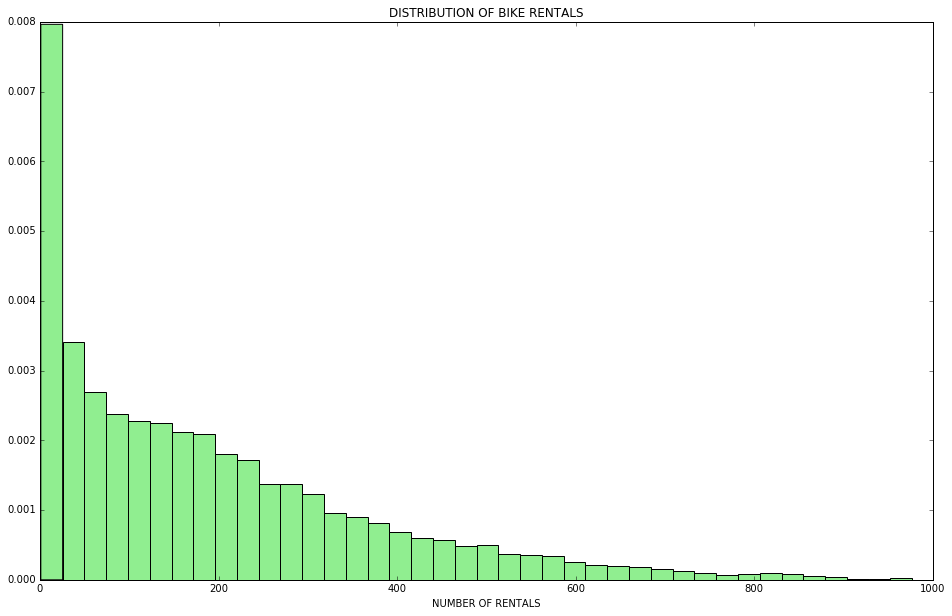

In [36]:
'''
Distribution of target variable
'''
# Collect all values of target variable
targets = records.map(lambda r: float(r[-1])).collect()

# Plotting
hist(targets, 
     bins=40, 
     color='lightgreen', 
     normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)
matplotlib.pyplot.title('DISTRIBUTION OF BIKE RENTALS')
matplotlib.pyplot.xlabel('NUMBER OF RENTALS')
matplotlib.pyplot.ylabel('')

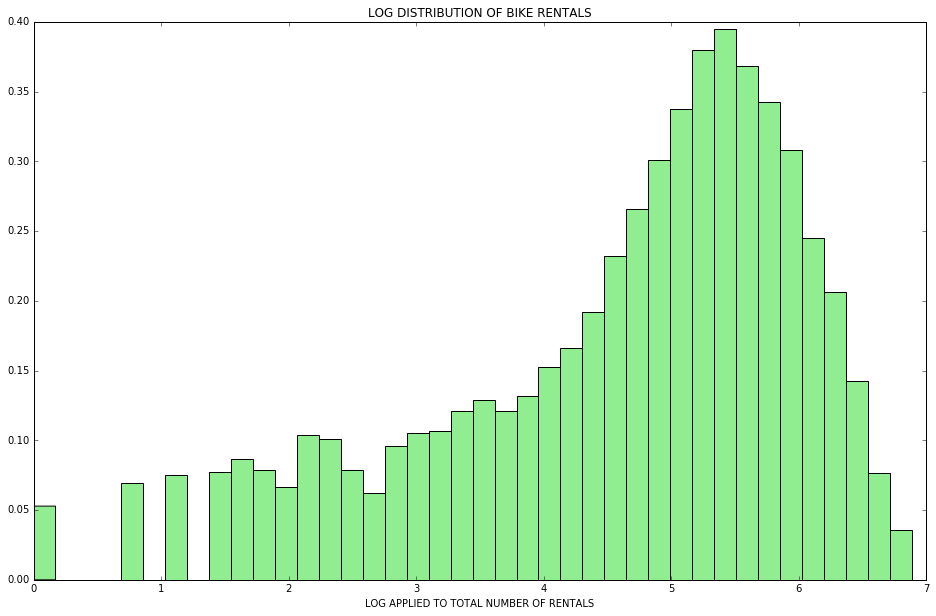

In [38]:
'''
Apply log transformation to target variable get a normal distribution
'''
# Log of target variable
log_targets = records.map(lambda r: np.log(float(r[-1]))).collect()

# Plotting
hist(log_targets, 
     bins=40, 
     color='lightgreen', 
     normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)
matplotlib.pyplot.title('LOG DISTRIBUTION OF BIKE RENTALS')
matplotlib.pyplot.xlabel('LOG APPLIED TO TOTAL NUMBER OF RENTALS')
matplotlib.pyplot.ylabel('')

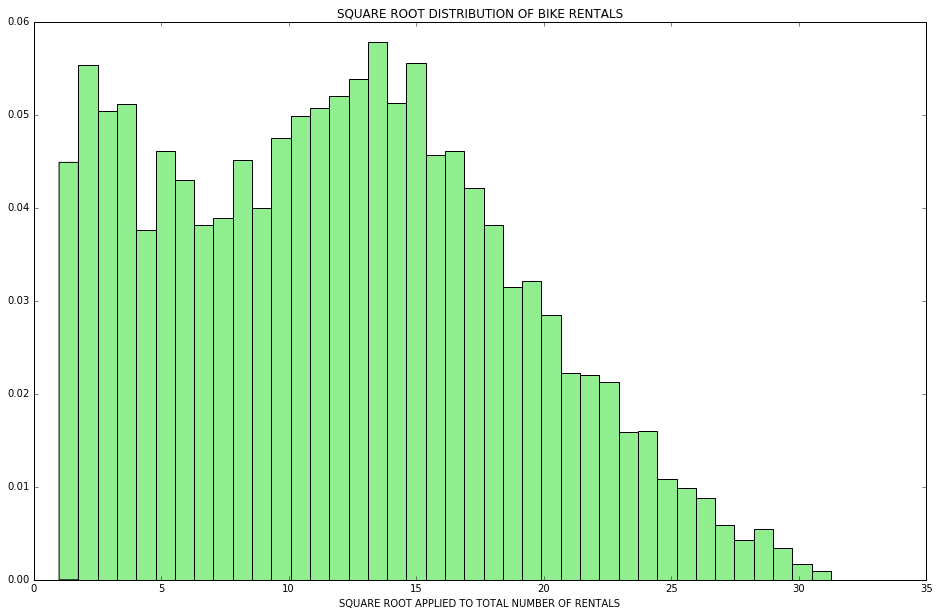

In [39]:
'''
Apply square root transformation to target variable
'''
# Applying square root transformation
sqrt_targets = records.map(lambda r: np.sqrt(float(r[-1]))).collect()

# Plotting
hist(sqrt_targets, 
     bins=40, 
     color='lightgreen', 
     normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)
matplotlib.pyplot.title('SQUARE ROOT DISTRIBUTION OF BIKE RENTALS')
matplotlib.pyplot.xlabel('SQUARE ROOT APPLIED TO TOTAL NUMBER OF RENTALS')
matplotlib.pyplot.ylabel('')

## Step 4.2: Training using the log transformed target variable ##

### Step 4.2.a: Training the linear regression model ###

In [40]:
'''
Training the model
'''
# Map log transformed label and the features using LabeledPoint
data_log = data.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))

# Train model
model_log = LinearRegressionWithSGD.train(data_log, 
                                          iterations=10, 
                                          step=0.1)

In [41]:
'''
Checking performance metrics and comparing with Linear regression performance on raw label values.
'''

# We take the exponent of the actual label and predicted labels to compare performance with original values so that
# they are transformed back to their original scale.
true_vs_predicted_log = data_log.map(lambda p: (np.exp(p.label), np.exp(model_log.predict(p.features))))

# Calculate metrics
mse_log = true_vs_predicted_log.map(lambda (t, p): squared_error(t, p)).mean()
mae_log = true_vs_predicted_log.map(lambda (t, p): abs_error(t, p)).mean()
rmsle_log = np.sqrt(true_vs_predicted_log.map(lambda (t, p): squared_log_error(t, p)).mean())

# Printing out the values
print "Mean Squared Error: %2.4f" % mse_log
print "Mean Absolute Error: %2.4f" % mae_log
print "Root Mean Squared Log Error: %2.4f" % rmsle_log

# true_vs_predicted taken from step 2.1
print "Non log-transformed predictions:\n" + str(true_vs_predicted.take(3))
print "Log-transformed predictions:\n" + str(true_vs_predicted_log.take(3))

Mean Squared Error: 50685.5559
Mean Absolute Error: 155.2955
Root Mean Squared Log Error: 1.5411
Non log-transformed predictions:
[(16.0, 117.89250386724845), (40.0, 116.2249612319211), (32.0, 116.02369145779235)]
Log-transformed predictions:
[(15.999999999999998, 28.080291845456223), (40.0, 26.959480191001774), (32.0, 26.654725629458007)]


### Step 4.2.b Training the Decision tree model ###

In [42]:
'''
Training the model
'''
# Log transform the label and wrap the labels and features using LabeledPoint
data_dt_log = data_dt.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))

# Train
dt_model_log = DecisionTree.trainRegressor(data_dt_log, {})

# Make prediction
preds_log = dt_model_log.predict(data_dt_log.map(lambda p: p.features))

In [43]:
'''
Performance metric evaluation
'''

# Actual log transformed label values
actual_log = data_dt_log.map(lambda p: p.label)

# Apply np.exp to the log transformed predicted labels and actual labels
true_vs_predicted_dt_log = actual_log.zip(preds_log).map(lambda (t, p): (np.exp(t), np.exp(p)))

# Calculate metrics
mse_log_dt = true_vs_predicted_dt_log.map(lambda (t, p): squared_error(t, p)).mean()
mae_log_dt = true_vs_predicted_dt_log.map(lambda (t, p): abs_error(t, p)).mean()
rmsle_log_dt = np.sqrt(true_vs_predicted_dt_log.map(lambda (t, p): squared_log_error(t, p)).mean())
print "Mean Squared Error: %2.4f" % mse_log_dt
print "Mean Absolute Error: %2.4f" % mae_log_dt
print "Root Mean Squared Log Error: %2.4f" % rmsle_log_dt

# Check prediction comparison
print "Non log-transformed predictions:\n" + str(true_vs_predicted_dt.take(3))
print "Log-transformed predictions:\n" + str(true_vs_predicted_dt_log.take(3))

Mean Squared Error: 14781.5760
Mean Absolute Error: 76.4131
Root Mean Squared Log Error: 0.6406
Non log-transformed predictions:
[(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945)]
Log-transformed predictions:
[(15.999999999999998, 37.530779787154508), (40.0, 37.530779787154508), (32.0, 7.2797070993907287)]


Taking the log transform worsened the performance of our Decision tree regressor(0.62 to 0.64). This is because the RMS LE penalizes relative error rather than absolute magnitude of errors. 

# Step 5: Tuning model parameters #

## Step 5.1: Creating training and testing split ##

Spark's Python API does not have `randomSplit` like scala to split the data and hence we have to do this manually.

In [44]:
'''
Create training and testing sets for linear model
'''

# Create dictionary using zipWithIndex() that creates RDD of (LabeledPoint, index) pairs.
# We reverse the (LabeledPoint, index) pair to (index, LabeledPoint) so we can work with the index keys.
data_with_idx = data.zipWithIndex().map(lambda (k, v): (v, k))

# Test data is 20% of total. sample() takes random sample.
test = data_with_idx.sample(False, 0.2, 42)

# Training data is the remaining 80% with keys not found in the testing data, done using subtractByKey()
train = data_with_idx.subtractByKey(test)

# Use map to extract just the value(LabeledPoint) from RDD and not the index.
train_data = train.map(lambda (idx, p): p)
test_data = test.map(lambda (idx, p) : p)

train_size = train_data.count()
test_size = test_data.count()
print "Training data size: %d" % train_size
print "Test data size: %d" % test_size
print "Total data size: %d " % num_data
print "Train + Test size : %d" % (train_size + test_size)

Training data size: 13934
Test data size: 3445
Total data size: 17379 
Train + Test size : 17379


In [45]:
'''
Create training and testing splits for the Decision tree regressor
'''
# Create dictionary using zipWithIndex() that creates RDD of (LabeledPoint, index) pairs.
# We reverse the (LabeledPoint, index) pair to (index, LabeledPoint) so we can work with the index keys.
data_with_idx_dt = data_dt.zipWithIndex().map(lambda (k, v): (v, k))

# 20% testing data
test_dt = data_with_idx_dt.sample(False, 0.2, 42)

# 80% training data
train_dt = data_with_idx_dt.subtractByKey(test_dt)

# Extract just the LabeledPoint data and not the index
train_data_dt = train_dt.map(lambda (idx, p): p)
test_data_dt = test_dt.map(lambda (idx, p) : p)

## Step 5.2: Tune parameters of Linear Regression model  ##

In [47]:
'''
Helper function to iterate through the parameters.

We will be tuning:

- iterations
- step size
- regularization(L1 or L2)
'''

def evaluate(train, test, iterations, step, regParam, regType, intercept):
    model = LinearRegressionWithSGD.train(train, 
                                          iterations, 
                                          step, 
                                          regParam = regParam, 
                                          regType = regType, 
                                          intercept = intercept)
    # Compare actual labels with predicted labels
    tp = test.map(lambda p: (p.label, model.predict(p.features)))
    # Compute RMS LE error metric as this is the metric the Kaggle competition is judging.
    rmsle = np.sqrt(tp.map(lambda (t, p): squared_log_error(t, p)).mean())
    return rmsle

### Iterations ###

SGD performance tends to increase with increase in number of iterations. But only up to a certain point after which it can overshoot the optimal solution.

[1, 5, 10, 20, 50, 100]
[2.8779465130028199, 2.0390187660391499, 1.7761565324837874, 1.5828778102209105, 1.4382263191764473, 1.4050638054019446]


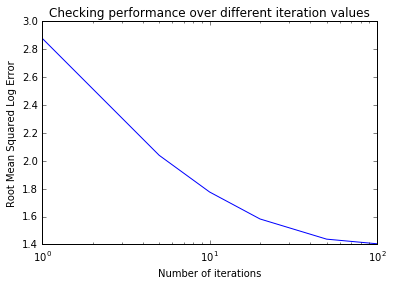

In [49]:
'''
Check for 1, 5, 10, 20, 50, 100 iterations using 0.01 step size.
'''
params = [1, 5, 10, 20, 50, 100]

# Use helper function
metrics = [evaluate(train_data, 
                    test_data, 
                    param, 
                    0.01, 
                    0.0, 
                    'l2', 
                    False) for param in params]
print params
print metrics

# Plotting
plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')
matplotlib.pyplot.title('Checking performance over different iteration values')
matplotlib.pyplot.xlabel('Number of iterations')
matplotlib.pyplot.ylabel('Root Mean Squared Log Error')

Lowest error comes at 100 iterations.

### Step size ### 

[0.01, 0.025, 0.05, 0.1, 1.0]
[1.7761565324837874, 1.4379348243997032, 1.4189071944747718, 1.5027293911925557, nan]


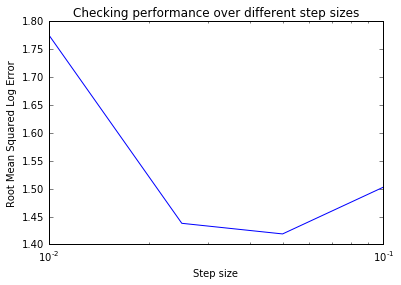

In [50]:
'''
Step size values - 0.01, 0.025, 0.05, 0.1, 1.0
'''
params = [0.01, 0.025, 0.05, 0.1, 1.0]
metrics = [evaluate(train_data, 
                    test_data, 
                    10, 
                    param, 
                    0.0, 
                    'l2', 
                    False) for param in params]
print params
print metrics
plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')
matplotlib.pyplot.title('Checking performance over different step sizes')
matplotlib.pyplot.xlabel('Step size')
matplotlib.pyplot.ylabel('Root Mean Squared Log Error')

Lowest error comes at step size 0.05

General rules for step size and number of iterations:
* Low step size and high number of iterations usually gives the best result.
* The lower the step size, the longer it takes for the model to converge thereby needing more iterations.

### Regularization ###

[0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
[1.5027293911925559, 1.5020646031965639, 1.4961903335175231, 1.4479313176192781, 1.4113329999970989, 1.5379824584440469, 1.8279564444985839]


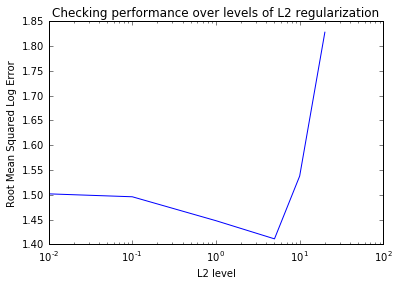

In [51]:
'''
Using different levels of L2 regularization
'''
params = [0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
metrics = [evaluate(train_data, 
                    test_data, 
                    10, 
                    0.1, 
                    param, 
                    'l2', 
                    False) for param in params]
print params
print metrics
plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')
matplotlib.pyplot.title('Checking performance over levels of L2 regularization')
matplotlib.pyplot.xlabel('L2 level')
matplotlib.pyplot.ylabel('Root Mean Squared Log Error')

[0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
[1.5027293911925559, 1.5026938950690176, 1.5023761634555699, 1.499412856617814, 1.4713669769550108, 1.7596682962964316, 4.7551250073268614]


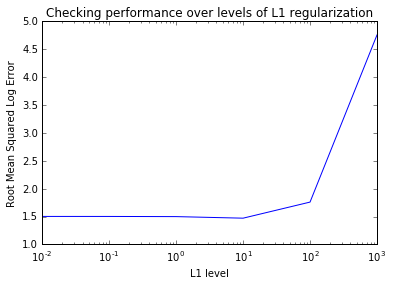

In [52]:
'''
Using different levels of L1 regularization
'''
params = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
metrics = [evaluate(train_data, 
                    test_data, 
                    10, 
                    0.1, 
                    param, 
                    'l1', 
                    False) for param in params]
print params
print metrics
plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')
matplotlib.pyplot.title('Checking performance over levels of L1 regularization')
matplotlib.pyplot.xlabel('L1 level')
matplotlib.pyplot.ylabel('Root Mean Squared Log Error')

In [55]:
'''
L1 regularization encourages sparse weight vectors. Looking into the number of zero vector weights at the different
levels of L1 regularization
'''

model_l1 = LinearRegressionWithSGD.train(train_data, 
                                         10, 
                                         0.1, 
                                         regParam=1.0, 
                                         regType='l1', 
                                         intercept=False)
model_l1_10 = LinearRegressionWithSGD.train(train_data, 
                                            10, 
                                            0.1, 
                                            regParam=10.0, 
                                            regType='l1', 
                                            intercept=False)
model_l1_100 = LinearRegressionWithSGD.train(train_data, 
                                             10, 
                                             0.1, 
                                             regParam=100.0, 
                                             regType='l1', 
                                             intercept=False)

print "L1 (1.0) number of zero weights: " + str(sum(model_l1.weights.array == 0))
print "L1 (10.0) number of zeros weights: " + str(sum(model_l1_10.weights.array == 0))
print "L1 (100.0) number of zeros weights: " + str(sum(model_l1_100.weights.array == 0))

L1 (1.0) number of zero weights: 4
L1 (10.0) number of zeros weights: 33
L1 (100.0) number of zeros weights: 58


Number of sparse vector weights increases at higher levels of L1 regularization.

### Intercept ###

The intercept is a constant value that accounts for the mean value of the target variable. If the data is already centered or normalized, an intercept is not necessary.

[False, True]
[1.4479313176192781, 1.4798261513419801]


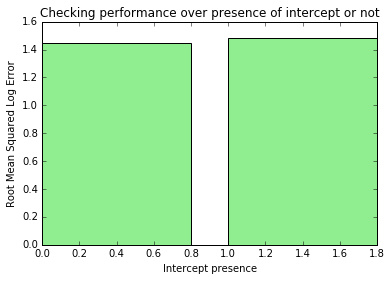

In [56]:
'''
Intercept values to be set or not using boolean
'''
params = [False, True]
metrics = [evaluate(train_data, 
                    test_data, 
                    10, 0.1, 1.0, 'l2', param) for param in params]
print params
print metrics
bar(params, metrics, color='lightgreen')
fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.title('Checking performance over presence of intercept or not')
matplotlib.pyplot.xlabel('Intercept presence')
matplotlib.pyplot.ylabel('Root Mean Squared Log Error')

Adding an intercept raises the RMS LE in our case.

## Step 5.3: Tuning the parameters of the Decision Tree model ##

We will tuning two parameters:

* Maximum tree depth
* Maximum number of bins

In [57]:
'''
Helper function to iterate over parameters
'''

# create a function to evaluate decision tree model
def evaluate_dt(train, test, maxDepth, maxBins):
    model = DecisionTree.trainRegressor(train, 
                                        {}, 
                                        impurity='variance', 
                                        maxDepth=maxDepth, 
                                        maxBins=maxBins)
    # Make predictions on the test set
    preds = model.predict(test.map(lambda p: p.features))
    # Get actual labels and store in 'actual'
    actual = test.map(lambda p: p.label)
    # Zip predicted labels with actual labels
    tp = actual.zip(preds)
    # RMS LE error metric
    rmsle = np.sqrt(tp.map(lambda (t, p): squared_log_error(t, p)).mean())
    return rmsle

### Maximum Tree Depth ###

[1, 2, 3, 4, 5, 10, 20]
[1.0280339660196287, 0.92686672078778276, 0.81807794023407532, 0.74060228537329209, 0.63583503599563096, 0.42630675767342086, 0.45134681265967197]


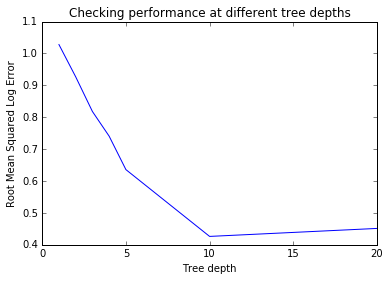

In [59]:
'''
Iterate over Tree depths keeping the bin value at default 32
'''
params = [1, 2, 3, 4, 5, 10, 20]
metrics = [evaluate_dt(train_data_dt, 
                       test_data_dt, 
                       param, 
                       32) for param in params]
print params
print metrics
plot(params, metrics)
fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.title('Checking performance at different tree depths')
matplotlib.pyplot.xlabel('Tree depth')
matplotlib.pyplot.ylabel('Root Mean Squared Log Error')

Model overfits at depths greater than 10

### Number of bins ###

[2, 4, 8, 16, 32, 64, 100]
[1.3069788763726049, 0.81721457107308615, 0.75745322513058744, 0.65509498325812077, 0.63583503599563096, 0.63583503599563096, 0.63583503599563096]


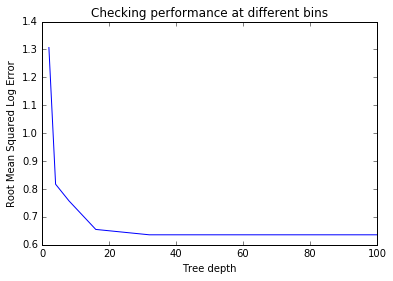

In [60]:
'''
Iterate over maximum number of bins
'''
params = [2, 4, 8, 16, 32, 64, 100]
metrics = [evaluate_dt(train_data_dt, 
                       test_data_dt, 
                       5, 
                       param) for param in params]
print params
print metrics
plot(params, metrics)
fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.title('Checking performance at different bins')
matplotlib.pyplot.xlabel('Tree depth')
matplotlib.pyplot.ylabel('Root Mean Squared Log Error')

The more the number of bins the more complex the model. Our best performance is at ~16 bins while keeping complexity 
in check.

# Step 6: Conclusion #

We have designed a model that can predict the use of the bike sharing system with good efficiency using the Decision Tree regressor model